In [17]:
import subprocess
import pandas as pd
import glob
import pathlib
from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
all_files = glob.glob('TE_result/Hypo/*')

In [3]:
has_hotspots = {}
all_hotspot = []
for path in all_files:
    try:
        te_class = path.split('/')[-1].split('.')[0]
        tmpdf = pd.read_csv(path, sep = '\t', header = None)
        tmpdf.index = tmpdf[0] + '-' + tmpdf[1].astype(str)
        has_hotspots[te_class] = len(set(tmpdf.index))
        all_hotspot += list(tmpdf.index)
    except:
        continue
    

In [14]:
df = pd.DataFrame(list(has_hotspots.items()), columns=['TE_Class', 'Hotpot_Overlap_Count'])
df = df.sort_values('Hotpot_Overlap_Count', ascending=False)
df = df[df['TE_Class'].isin(['DNA','LTR','LINE','SINE'])]

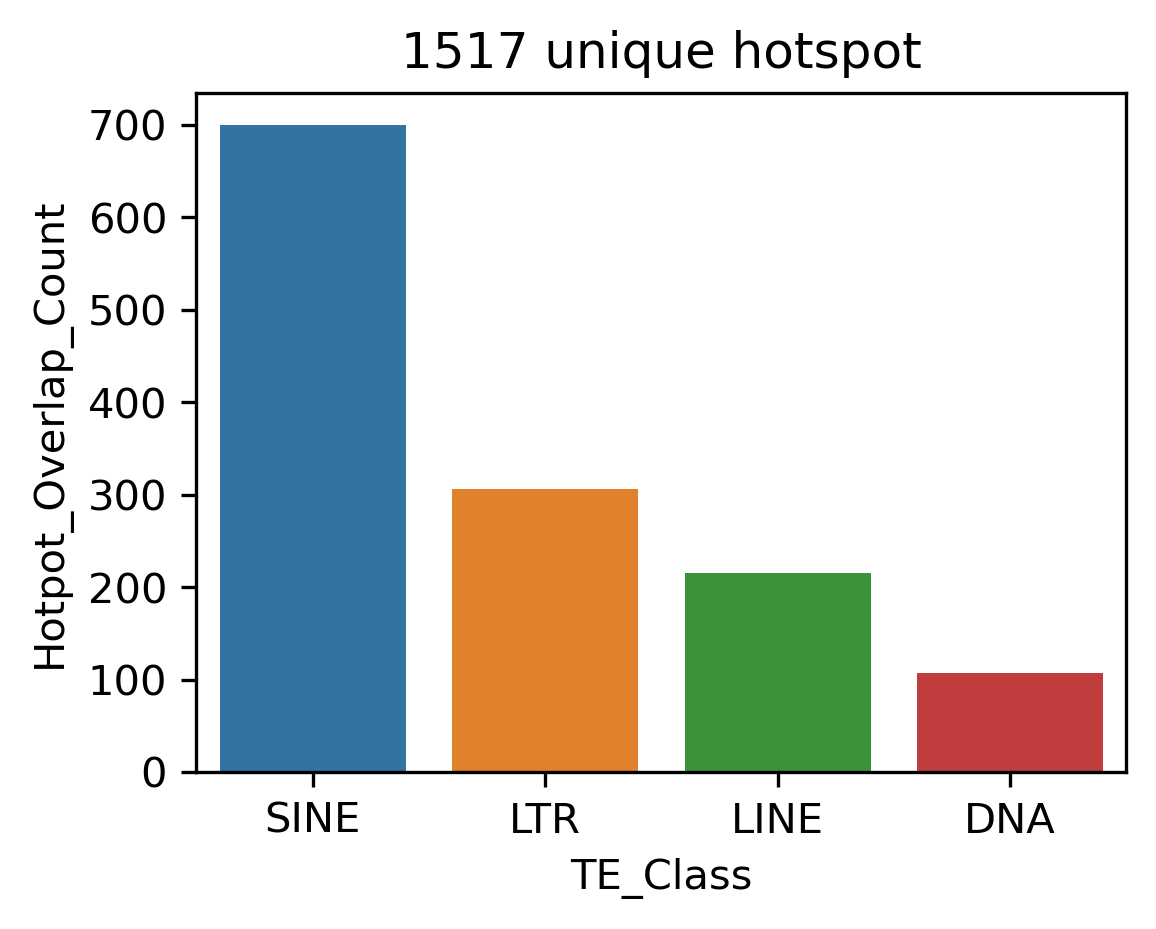

In [22]:
fig, ax = plt.subplots(figsize = (4,3), dpi = 300)
sns.barplot(data = df, 
            x = 'TE_Class', 
            y = 'Hotpot_Overlap_Count')
ax.set_title(f"{len(set(all_hotspot))} unique hotspot")
fig.savefig(f"figure/{_type}.Hotspot.overlap_with_te.pdf", bbox_inches = 'tight')

In [21]:
ct = 'shared'
_type = 'Hypo'
_dir = '500_result'
hotspot_bed = f'500_result/{_type}.hotspot.bed'
#hotspot_bed = '500_result/non_hotspots.bed' 
#hotspot_bed = f"{_dir}/{_type}.hotspot.shared.bed"
te_bed = '/gale/netapp/home/wtian/refs/mouse/mm10/repeatmasker/mm10.repeatmasker.repClass-SINE.bed'

In [6]:
hotspot_df = pd.read_csv(hotspot_bed, sep = '\t', header = None)
hotspot_df.head()

,0,1,2
0,chr1,131056500,131057000
1,chr1,131055000,131055500
2,chr1,131054500,131055000
3,chr1,130984500,130985000
4,chr1,131239000,131239500


In [7]:
# hotspot_df[3] = hotspot_df.index
# hotspot_df[3] = f"{_type}" + hotspot_df[3].astype(str)

In [8]:
# hotspot_df.to_csv(f'GAT/{_type}.bed', sep = '\t', header = None, index = None)

In [9]:
all_te_beds = glob.glob('/gale/netapp/home/wtian/refs/mouse/mm10/repeatmasker/*repClass-*.bed')
te_class_to_bed_path = {}
for path in all_te_beds:
    _class = pathlib.Path(path).name.split('.')[-2].split('-')[-1]
    te_class_to_bed_path[_class] = path

In [10]:
for _class, te_bed in te_class_to_bed_path.items():
    outpath = f'TE_result/{_type}/{_class}.hostpot.intesect.bed'
    command = f"bedtools intersect -a {hotspot_bed} -b {te_bed} -wa -wb > {outpath}"
    subprocess.run(command, shell = True)

In [11]:
from pandas.errors import EmptyDataError
all_overlap  = []
for path in glob.glob(f'TE_result/{_type}/*'):
    try:
        tmpdf = pd.read_csv(path, sep = '\t', header = None)
        all_overlap.append(tmpdf)
    except EmptyDataError:
        print(path)
        

TE_result/Hypo/Retroposon.hostpot.intesect.bed
TE_result/Hypo/RC.hostpot.intesect.bed
TE_result/Hypo/RNA.hostpot.intesect.bed
TE_result/Hypo/rRNA.hostpot.intesect.bed
TE_result/Hypo/snRNA.hostpot.intesect.bed
TE_result/Hypo/srpRNA.hostpot.intesect.bed


In [35]:
all_overlap = pd.concat(all_overlap)
all_overlap['hostpot_id'] = all_overlap[0] + '_' + all_overlap[1].astype(str) + '_' + all_overlap[2].astype(str)
all_overlap.head()

,0,1,2,3,4,5,6,7,8,9,hostpot_id
0,chr1,135830000,135830500,chr1,135830130,135830177,-,MER5A,DNA,hAT-Charlie,chr1_135830000_135830500
1,chr1,191612500,191613000,chr1,191612698,191612868,-,MER2B,DNA,TcMar-Tigger,chr1_191612500_191613000
2,chr1,185243000,185243500,chr1,185243296,185243477,+,URR1A,DNA,hAT-Charlie,chr1_185243000_185243500
3,chr1,34202500,34203000,chr1,34202989,34203214,+,URR1A,DNA,hAT-Charlie,chr1_34202500_34203000
4,chr1,37402000,37402500,chr1,37402182,37402324,-,MER63A,DNA,hAT-Blackjack,chr1_37402000_37402500


In [36]:
to_plot = all_overlap[9].value_counts()
to_plot.head()

Simple_repeat    502
Alu              287
B4               236
ERVL-MaLR        158
MIR              157
Name: 9, dtype: int64

In [45]:
test_tes = to_plot[to_plot >= 15].index
te_class = all_overlap[all_overlap[9].isin(test_tes)][8].value_counts().index

In [57]:
for _tmp_te_class in te_class:
    te_bed = pd.read_csv(f'/gale/netapp/home/wtian/refs/mouse/mm10/repeatmasker/mm10.repeatmasker.repClass-{_tmp_te_class}.bed',
                        sep = '\t', header = None)
    use_te_bed = te_bed[te_bed[6].isin(test_tes)]
    for _tmp, tmpdf in use_te_bed.groupby(6):
        _tmp = _tmp.replace('(','').replace(')','')
        tmpdf.to_csv(f"GAT/te_family_bed/{_tmp_te_class}_{_tmp}.bed", sep = '\t', header = None, index = None)
    #     break
    # break

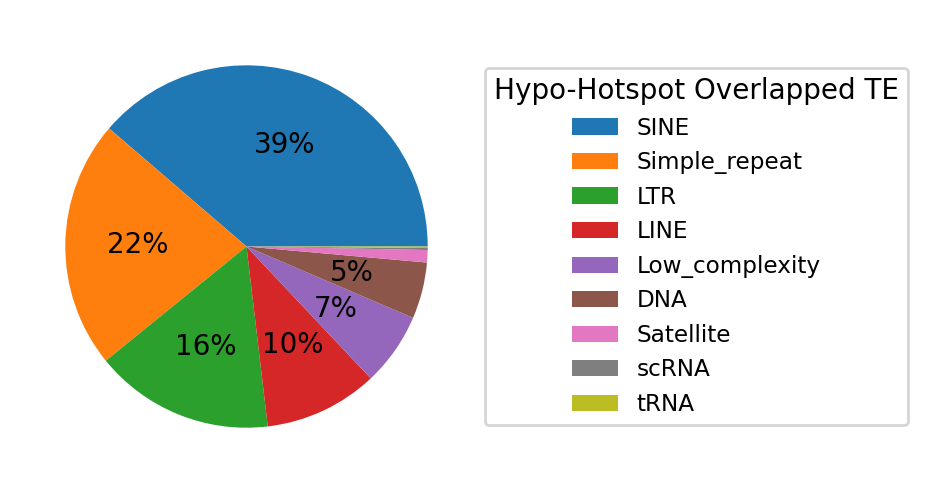

In [16]:
import matplotlib.pyplot as plt

def custom_autopct(pct):
    return ('%1.0f%%' % pct) if pct > 5 else ''

fig, ax = plt.subplots(figsize = (4,3), dpi = 200)
wedges, texts, autotexts = ax.pie(to_plot.values, autopct=custom_autopct)
ax.legend(wedges, to_plot.index,
          title=f"{_type}-Hotspot Overlapped TE",
          loc="center left",fontsize='small',
          bbox_to_anchor=(1, 0, 0.5, 1))


In [17]:
print(f"{len(all_overlap['hostpot_id'].unique())}/{hotspot_df.shape[0]} hypo hotspot overlap with TE regions")

1517/3519 hypo hotspot overlap with TE regions


## GAT enrichment

['GAT/gat-DNA-rep.rlt',
 'GAT/gat-SINE-rep.rlt',
 'GAT/gat-LINE-rep.rlt',
 'GAT/gat-LTR-rep.rlt',
 'GAT/gat-RNA-rep.rlt',
 'GAT/gat-Simple_repeat-rep.rlt',
 'GAT/gat-somple-Low_complexity.rlt']

In [28]:
toplot = df[['annotation','observed','expected']].melt(id_vars='annotation')
toplot.columns = ['Genome Feature', '','count']

In [29]:
toplot = toplot.sort_values(['Genome Feature',''])
pairs = toplot.sort_values(['Genome Feature',''])[['Genome Feature','']].values

In [30]:
toplot

,Genome Feature,,count
12,+,expected,9830.6885
14,+,expected,71193.3384
17,+,expected,163288.5879
18,+,expected,98503.5582
20,+,expected,41.0329
22,+,expected,38739.6188
23,+,expected,13063.3318
0,+,observed,7455.0000
2,+,observed,38460.0000
5,+,observed,18185.0000
